## Requirement

In [1]:
import os
import sys 
import json
import glob
import random
import collections
import time
import re
import math
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut, apply_modality_lut

from random import shuffle
from sklearn import model_selection as sk_model_selection

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.metrics import AUC

import tensorflow as tf
from tqdm import tqdm

In [2]:
base_path = '../../data'
 
mri_types = ['FLAIR','T1w','T1wCE','T2w']
mri_types_id=0 # 0,1,2,3



IMAGE_SIZE = 224
MODALITY_LUT = True
VOI_LUT = True

BATCH_SIZE= 4
EXCLUDE = [109, 123, 709]
TYPES = ["FLAIR", "T1w", "T2w", "T1wCE"]
IMAGE_TYPE = "T1wCE"

num_folds=5
Selected_fold=1 #1,2,3,4,5 

In [3]:
train_df = pd.read_csv("../../data/train_df.csv")
train_df = train_df[~train_df.BraTS21ID.isin(EXCLUDE)]
train_df['Fold'] = 'train'
test_df = pd.read_csv("../../data/test_df.csv")
test_df['Fold'] = 'test'
train_df.head()

,BraTS21ID,MGMT_value,Fold
0,185,1,train
1,816,1,train
2,707,1,train
3,683,0,train
4,6,1,train


In [4]:
len(train_df), len(test_df)

(466, 117)

### load_dicom(path,modality_lut=MODALITY_LUT,voi_lut=VOI_LUT,size=224)
환자 id 로 경로를 찾아가며 이미지 사이즈는 default 224 임

In [5]:
def load_dicom(path,modality_lut=MODALITY_LUT,voi_lut=VOI_LUT,size=224):
    # read dicom
    dicom = pydicom.read_file(path)

    # pixel array
    data = dicom.pixel_array
    
    if modality_lut:
        # 기울기와 절편을 적용해주지 않으면 brightness가 엉망이 될 수도 있다고 한다.
        data = apply_modality_lut(data,dicom)
    
    if voi_lut :
        # window center와 window width에 맞춰 영상의 픽셀값 조정
        data = apply_voi_lut(data,dicom)

    # 16비트 짜리 dicom 이미지를 8비트 (0 ~ 255) 픽셀 데이터로 rescale
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)

    # resize
    return cv2.resize(data, (size, size))

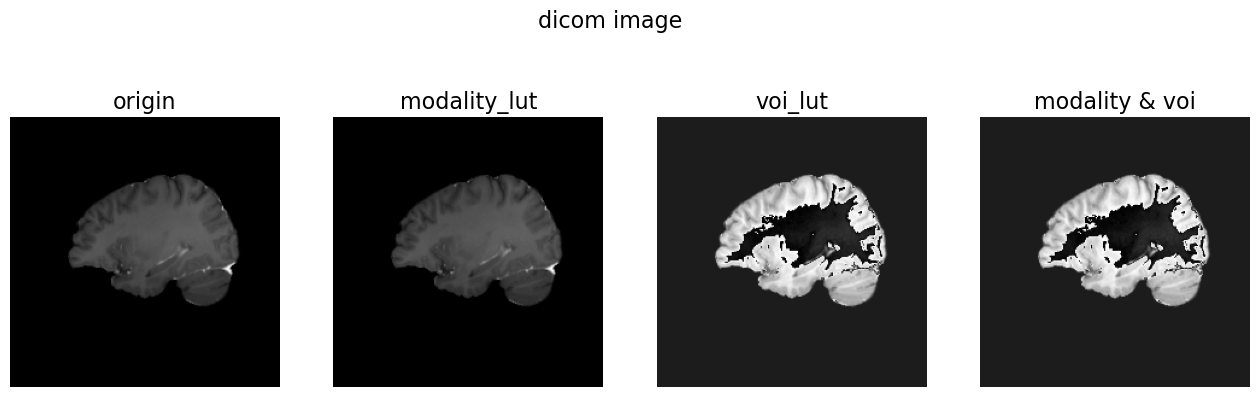

In [6]:
path = '../../data/train/00025/T1wCE/Image-80.dcm'

plt.figure(figsize=(16, 5))
plt.suptitle(f"dicom image", fontsize=16)


plt.subplot(1, 4, 1)
data = load_dicom(path,modality_lut=False,voi_lut=False,size=224)
plt.imshow(data, cmap="gray")
plt.axis("off")
plt.title("origin", fontsize=16)

plt.subplot(1, 4, 2)
data = load_dicom(path,modality_lut=True,voi_lut=False,size=224)
plt.imshow(data, cmap="gray")
plt.axis("off")
plt.title("modality_lut", fontsize=16)

plt.subplot(1, 4, 3)
data = load_dicom(path,modality_lut=False,voi_lut=True,size=224)
plt.imshow(data, cmap="gray")
plt.axis("off")
plt.title("voi_lut", fontsize=16)

plt.subplot(1, 4, 4)
data = load_dicom(path,modality_lut=True,voi_lut=True,size=224)
plt.imshow(data, cmap="gray")
plt.axis("off") 
plt.title("modality & voi", fontsize=16)

plt.show()

### get_all_image_paths(brats21id, image_type=IMAGE_TYPE, folder='train')
폴더 안의 모든 이미지 파일 중 학습/판단의 자료로 사용할 이미지의 경로를 반환 하는 함수<br>
환자 id 로 경로를 찾아가며, 이미지 종류 (FLAIR, T1w, T2w, T1wCE), train/test를 입력 받음 default는 train.<br>
시작 이미지는 전체 이미지의 25% 지점 / 마지막 이미지는 전체 이미지의 75% 지점 / interval 은 전체 이미지가 10장 미만이면 모든 이미지, 10장 이상이면 3장씩 건너뜀


In [7]:
def get_all_image_paths(brats21id, image_type=IMAGE_TYPE, folder='train'): 
    assert(IMAGE_TYPE in TYPES)
    
    patient_path = os.path.join(
        base_path + "/%s/" % folder,
        str(brats21id).zfill(5),
    )

    paths = sorted(
        glob.glob(os.path.join(patient_path, image_type, "*")), 
        key=lambda x: int(x[:-4].split("-")[-1]),
    )
    
    num_images = len(paths)
    
    start = int(num_images * 0.25)
    end = int(num_images * 0.75)

    interval = 3
    
    if num_images < 10: 
        interval = 1
    
    return np.array(paths[start:end:interval])

In [8]:
get_all_image_paths(25, 'T1wCE', folder='train')

array(['../../data/train/00025\\T1wCE\\Image-33.dcm',
       '../../data/train/00025\\T1wCE\\Image-36.dcm',
       '../../data/train/00025\\T1wCE\\Image-39.dcm',
       '../../data/train/00025\\T1wCE\\Image-42.dcm',
       '../../data/train/00025\\T1wCE\\Image-45.dcm',
       '../../data/train/00025\\T1wCE\\Image-48.dcm',
       '../../data/train/00025\\T1wCE\\Image-51.dcm',
       '../../data/train/00025\\T1wCE\\Image-54.dcm',
       '../../data/train/00025\\T1wCE\\Image-57.dcm',
       '../../data/train/00025\\T1wCE\\Image-60.dcm',
       '../../data/train/00025\\T1wCE\\Image-63.dcm',
       '../../data/train/00025\\T1wCE\\Image-66.dcm',
       '../../data/train/00025\\T1wCE\\Image-69.dcm',
       '../../data/train/00025\\T1wCE\\Image-72.dcm',
       '../../data/train/00025\\T1wCE\\Image-75.dcm',
       '../../data/train/00025\\T1wCE\\Image-78.dcm',
       '../../data/train/00025\\T1wCE\\Image-81.dcm',
       '../../data/train/00025\\T1wCE\\Image-84.dcm',
       '../../data/train/000

### get_all_images(brats21id, image_type=IMAGE_TYPE, folder='train', size=IMAGE_SIZE, modality_lut=MODALITY_LUT, voi_lut=True)
- 환자 아이디로 경로를 지정하여 get_all_image_paths 호출, 환자 아이디로된 경로 내의 이미지들을 load_dicom 을 통해 하나의 리스트로 반환
- 종태님 코드에서 modality와 voi 옵션을 추가

In [12]:
def get_all_3Dimages(brats21id, image_type=IMAGE_TYPE, folder='train', size=IMAGE_SIZE, modality_lut=MODALITY_LUT, voi_lut=True):
    return [load_dicom(path,modality_lut=modality_lut,voi_lut=voi_lut,size=224) for path in get_all_image_paths(brats21id, image_type, folder)]

In [13]:
all_images = get_all_3Dimages(25, 'T1wCE', folder='train', size=IMAGE_SIZE, modality_lut=True, voi_lut=True)
all_images

[array([[65, 65, 65, ..., 65, 65, 65],
        [65, 65, 65, ..., 65, 65, 65],
        [65, 65, 65, ..., 65, 65, 65],
        ...,
        [65, 65, 65, ..., 65, 65, 65],
        [65, 65, 65, ..., 65, 65, 65],
        [65, 65, 65, ..., 65, 65, 65]], dtype=uint8),
 array([[154, 154, 154, ..., 154, 154, 154],
        [154, 154, 154, ..., 154, 154, 154],
        [154, 154, 154, ..., 154, 154, 154],
        ...,
        [154, 154, 154, ..., 154, 154, 154],
        [154, 154, 154, ..., 154, 154, 154],
        [154, 154, 154, ..., 154, 154, 154]], dtype=uint8),
 array([[14, 14, 14, ..., 14, 14, 14],
        [14, 14, 14, ..., 14, 14, 14],
        [14, 14, 14, ..., 14, 14, 14],
        ...,
        [14, 14, 14, ..., 14, 14, 14],
        [14, 14, 14, ..., 14, 14, 14],
        [14, 14, 14, ..., 14, 14, 14]], dtype=uint8),
 array([[243, 243, 243, ..., 243, 243, 243],
        [243, 243, 243, ..., 243, 243, 243],
        [243, 243, 243, ..., 243, 243, 243],
        ...,
        [243, 243, 243, ..., 2

In [15]:
len(all_images)

22